In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from keras.datasets import cifar10

c:\Users\cau\miniconda3\envs\het\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
(X_train, y_train) , (X_test, y_test) = cifar10.load_data()
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# valdiation set
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# training set
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# development set
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# test set
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]


print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000, 1)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000, 1)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000, 1)


In [3]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print ('Training data shape: ', X_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Test data shape: ', X_test.shape)
print ('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


In [4]:
mean_image = np.mean(X_train, axis=0).astype('uint8')

X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [5]:
class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
      
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # y는 0...K-1 를 갖는다고 가정 (K는 classes 개수)
    if self.W is None:
      # 초기화
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # gradient descent W
    loss_history = []
    for it in range(num_iters):
      X_batch = None
      y_batch = None
      
      # batch size로 샘플링
      random_idxs = np.random.choice(num_train, batch_size)
      X_batch = X[random_idxs]
      y_batch = y[random_idxs]

      # loss 와 gradient 계산하기
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)

      self.W -= learning_rate * grad  

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):

    y_pred = np.zeros(X.shape[1])

    # prediction(y_pred)에서 가장 높은 값 추출
    y_pred = np.argmax(np.dot(X, self.W), axis=1)
    
    return y_pred
  
  def loss(self, W, X_batch, y_batch, reg):

    pass


def svm_loss_vectorized(W, X, y, reg):


  C = W.shape[1]
  N = X.shape[0]
  loss = 0.0
  dW = np.zeros(W.shape) # initialize the gradient as zero

  scores = np.dot(X, W)    # (N, C)
  
  correct_scores = scores[np.arange(N), y]  # (N, )
  margins = np.maximum(scores - correct_scores.reshape(N, 1) + 1.0, 0)  # (N, C)
  margins[np.arange(N), y] = 0
  loss = np.sum(margins) / N
  loss += 0.5 * reg * np.sum(W * W)

  
  dscores = np.zeros_like(scores)  # (N, C)
  dscores[margins > 0] = 1  
  dscores[np.arange(N), y] -= np.sum(dscores, axis=1)   #  (N, 1) = (N, 1)

  dW = np.dot(X.T, dscores) 
  dW /= N
  dW += reg * W 

  return loss, dW

def softmax_loss_vectorized(W, X, y, reg):

  # Initialize the loss and gradient to zero.
  N = X.shape[0]
  loss = 0.0
  dW = np.zeros_like(W)

  
  # forward
  score = np.dot(X, W)   # (N, C)
  out = np.exp(score)
  out /= np.sum(out, axis=1, keepdims=True)   # (N, C)
  loss -= np.sum(np.log(out[np.arange(N), y]))
  loss /= N
  loss += 0.5 * reg * np.sum(W**2)

  # backward
  dout = np.copy(out)   # (N, C)
  dout[np.arange(N), y] -= 1
  dW = np.dot(X.T, dout)  # (D, C)
  dW /= N
  dW += reg * W

  return loss, dW


In [6]:
class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, X_batch, y_batch, reg):
      return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """

  def loss(self, X_batch, y_batch, reg):
    return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)


In [7]:
import time

svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train.flatten(), learning_rate=1e-7, reg=5e4, num_iters=1500, verbose=True)
toc = time.time()
print ('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 812.548349
iteration 100 / 1500: loss 293.565043
iteration 200 / 1500: loss 114.261617
iteration 300 / 1500: loss 49.198544
iteration 400 / 1500: loss 26.708532
iteration 500 / 1500: loss 14.135865
iteration 600 / 1500: loss 14.917248
iteration 700 / 1500: loss 11.112203
iteration 800 / 1500: loss 10.172685
iteration 900 / 1500: loss 10.746136
iteration 1000 / 1500: loss 10.329157
iteration 1100 / 1500: loss 13.725946
iteration 1200 / 1500: loss 12.225270
iteration 1300 / 1500: loss 10.046539
iteration 1400 / 1500: loss 11.407408
That took 3.281669s


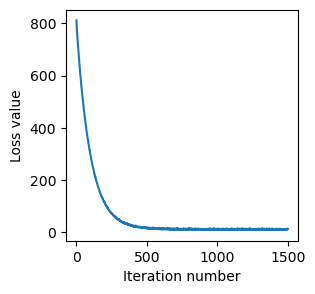

In [8]:
plt.figure(figsize=(3, 3))
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [9]:
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.100057
validation accuracy: 0.097324
